In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [3]:
X, _ = load_data('ex4data1.mat')

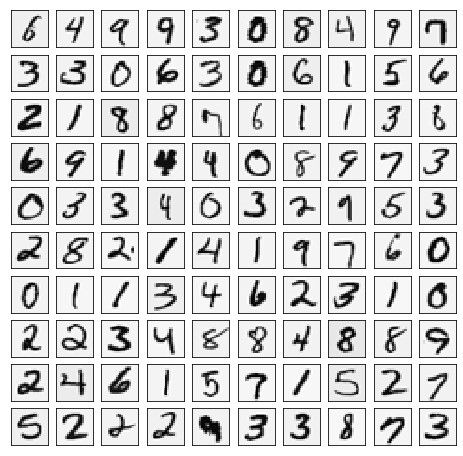

In [5]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            
plot_100_image(X)
plt.show()

In [6]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)#增加全部为1的一列
X.shape

(5000, 401)

In [7]:
y_raw

array([10, 10, 10, ...,  9,  9,  9], dtype=uint8)

In [9]:
def expand_y(y):
#     """expand 5000*1 into 5000*10
#     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1

        res.append(y_array)

    return np.array(res)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致

y = expand_y(y_raw)

In [11]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [12]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

In [13]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))
# 序列化2矩阵
# 在这个nn架构中，我们有theta1（25,401），theta2（10,26），它们的梯度是delta1，delta2

In [14]:
theta = serialize(t1, t2)  # 扁平化参数，25*401+10*26=10285
theta.shape

(10285,)

feed forward（前向传播）¶
(400 + 1) -> (25 + 1) -> (10)

In [16]:
X.shape, theta.shape

((5000, 401), (10285,))

In [17]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def deserialize(seq):
    return seq[:25 * 401].reshape(25,401), seq[25 * 401:].reshape(10, 26)

def feed_forward(theta, X):
    """apply to architecture 400+1 * 25+1 *10
    X: 5000 * 401
    """
    t1, t2 = deserialize(theta)
    m = X.shape[0]
    
    a1 = X # 5000 * 401
    z2 = a1 @ t1.T # 5000 * 25
    
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)  # 5000*26
    z3 = a2 @ t2.T  # 26 * 10
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

In [19]:
_, _, _, _, h = feed_forward(theta, X)
h.shape, h # 5000*10

((5000, 10),
 array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]]))

### cost function
![12](https://github.com/fengdu78/Coursera-ML-AndrewNg-Notes/raw/4235cf10673207669f92cf9d952936bc70517edd/code/img/nn_cost.png)

In [20]:
y.shape

(5000, 10)

In [23]:
def cost(theta, X, y):
#     """calculate cost
#     y: (m, k) ndarray
#     """
    m = X.shape[0]  #  size m
    _, _, _, _, h = feed_forward(theta, X)
    pair = -np.multiply(y, np.log(h)) -np.multiply(1-y, np.log(1-h))
#     return pair.sum()/m
    return np.sum(pair) / m 

In [24]:
cost(theta, X, y)

0.2876291651613189

### 正则化代价函数
![13](https://github.com/fengdu78/Coursera-ML-AndrewNg-Notes/raw/4235cf10673207669f92cf9d952936bc70517edd/code/img/nn_regcost.png)

In [25]:
def regularized_cost(theta, X, y, l=1):
    """the first column of t1 and t2 is intercept theta, 
    ignore them when you do regularization"""
    t1, t2 = deserialize(theta)
    m = X.shape[0]
    
    reg_t1 = (1/(2*m)) * np.power(t1[:, 1:], 2).sum()
    reg_t2 = (1/(2*m)) * np.power(t2[:, 1:], 2).sum()
    return cost(theta, X, y) + reg_t1 + reg_t2

In [28]:
t1[:, 1:].shape, t1.shape

((25, 400), (25, 401))

In [29]:
regularized_cost(theta, X, y)

0.38376985909092365

### 反向传播

In [31]:
X.shape,y.shape,t1.shape, t2.shape,theta.shape

((5000, 401), (5000, 10), (25, 401), (10, 26), (10285,))

In [32]:
def sigmoid_gradient(z):
    """
    pairwise op is key for this to work on both vector and matrix
    """
    return np.multiply(sigmoid(z), 1 - sigmoid(z))


sigmoid_gradient(0)

0.25

In [37]:
def gradient(theta, X, y):
    t1, t2 = deserialize(theta) # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    
    delta1 = np.zeros(t1.shape) # 25,401)
    delta2 = np.zeros(t2.shape)  # (10,26)
    
    a1,z2,a2,z3,h = feed_forward(theta, X)
    
    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)  
        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1,10)
        d3i = hi - yi   # (1,10)  反向误差第一层
        
        # make it (1, 26) to compute d2i
        z2i = np.insert(z2i, 0, np.ones(1))
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))
        
        # careful with np vector transpose
        # (1, 10).T @ (1, 26) -> (10, 26)
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  
        # (1, 25).T @ (1, 401) -> (25, 401)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)  
    
    delta1 = delta1/m
    delta2 = delta2/m
    return serialize(delta1, delta2)

In [38]:
d1, d2 = deserialize(gradient(theta, X, y))

In [39]:
d1.shape, d2.shape

((25, 401), (10, 26))

In [41]:
d2[0]

array([ 6.28737643e-04,  7.50946274e-04,  9.87964596e-05,  1.48819864e-03,
        7.31802078e-04,  1.38113760e-03, -1.59325422e-04, -6.68870887e-04,
       -1.24979363e-03, -9.66225987e-05,  7.19244384e-04, -5.10976177e-04,
        1.11120644e-03, -6.43551911e-04, -6.95182470e-04, -9.47091610e-04,
        2.00794722e-04,  9.50724940e-04, -5.42000276e-04, -5.05540551e-05,
        2.22327563e-04,  5.06964221e-04,  2.45312090e-04,  1.39987507e-03,
        5.07147165e-04,  8.73666979e-04])

## 9.5 梯度检验
参考视频: 9 - 5 - Gradient Checking (12 min).mkv

当我们对一个较为复杂的模型（例如神经网络）使用梯度下降算法时，可能会存在一些不容易察觉的错误，意味着，虽然代价看上去在不断减小，但最终的结果可能并不是最优解。

为了避免这样的问题，我们采取一种叫做梯度的数值检验（Numerical Gradient Checking）方法。这种方法的思想是通过估计梯度值来检验我们计算的导数值是否真的是我们要求的。

对梯度的估计采用的方法是在代价函数上沿着切线的方向选择离两个非常近的点然后计算两个点的平均值用以估计梯度。即对于某个特定的 ，我们计算出在 - 处和 + 的代价值（是一个非常小的值，通常选取 0.001），然后求两个代价的平均，用以估计在  处的代价值。

In [42]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon * 2)

    theta_matrix = expand_array(theta)  # expand to (10285, 10285)
    epsilon_matrix = np.identity(len(theta)) * epsilon

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                                    for i in range(len(theta))])

    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)

    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))
    
    
    
def expand_array(arr):
    """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

In [52]:
import time
start = time.time()
print(start, "->")
gradient_checking(theta, X, y, epsilon= 0.0001)#这个运行很慢，谨慎运行
end = time.time()
print(end, "->", start-end)

1592664346.2941623 ->
If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 2.1457557907925204e-09

1592664658.9174392 -> -312.62327694892883


### regularized gradient

In [53]:
def regularized_gradient(theta, X, y, l=1):
    """don't regularize theta of bias terms"""
    
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)
    
    t1[:, 0] = 0
    reg_term_d1 = (1/m) * t1
    delta1 = delta1 + reg_term_d1
    
    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)  

In [54]:
start = time.time()
gradient_checking(theta, X, y, epsilon=0.0001, regularized=True)#这个运行很慢，谨慎运行
end = time.time()
print("->", start-end)

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 3.1905859034173364e-09

-> -305.80475425720215


## ready to train the model

In [46]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(10285)  # 25*401 + 10*26

    res = opt.minimize(fun=regularized_cost,
                       x0=init_theta,
                       args=(X, y, 1),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'maxiter': 400})
    return res

In [47]:
res = nn_training(X, y)#慢
res

     fun: 0.33246194489716246
     jac: array([ 5.06367454e-05,  1.66403557e-08, -1.49376478e-08, ...,
       -3.06833299e-05, -2.84620254e-05,  4.27101601e-06])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 23
  status: 3
 success: False
       x: array([ 0.00000000e+00,  8.32017783e-05, -7.46882389e-05, ...,
       -1.20549988e-01,  3.01925474e+00, -2.31262779e+00])

In [48]:
# 准确率
_, y_answer = load_data('ex4data1.mat')
y_answer[:20]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10], dtype=uint8)

In [49]:
final_theta = res.x
def show_accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(theta, X)

    y_pred = np.argmax(h, axis=1) + 1

    print(classification_report(y, y_pred))

# show the hidden layer

def plot_hidden_layer(theta):
    """
    theta: (10285, )
    """
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:, 1:]  # ger rid of bias term theta

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


# nn functions starts here ---------------------------
# ps. all the y here is expanded version (5000,10)

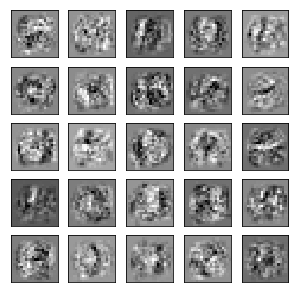

In [50]:
plot_hidden_layer(final_theta)
plt.show()